# 다양한 OCR모델 비교하기
--------

## Step1. 검증용 데이터셋 준비

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### Google OCR API

#### STEP 1) 구글의 파이썬 API 인터페이스 모듈을 아래와 설치합니다.

```python
$ pip install --upgrade google-api-python-client
$ pip install google-cloud-vision
```

#### STEP 2) Google Cloud Vision API 사용

```python
$ cp ~/Downloads/sheet-contents-xxxx.json ~/aiffel/ocr_python/my_google_api_key.json  
```

#### STEP 3) 인증키 경로 등록 후 커널 재기동     
터미널을 열고 아래와 같이 인증키 경로 변수를 등록한 후 커널을 종료하고 재기동합니다. 

```python
$ export GOOGLE_APPLICATION_CREDENTIALS=$HOME/aiffel/ocr_python/my_google_api_key.json
$ echo "export GOOGLE_APPLICATION_CREDENTIALS=$HOME/aiffel/ocr_python/my_google_api_key.json" >> ~/.bashrc
```

#### STEP 4) API 사용 테스트

In [2]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [4]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'# [[YOUR IMAGE FILE PATH]]   

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

-rw-rw-r-- 1 aiffel aiffel 2352  3월 11 10:15 /home/aiffel/aiffel/ocr_python/my_google_api_key.json
Texts:

"논문 공유 서비
해외 유수의 대학과 기업은
다양한 기술의 확대에 기여 중
ArXiv
MODULABS
소스 코드 공유
GitHub
Stan
ford
MIT
공유 문화의 형성
→ 빠른 기술 발전
Google
Coursera
stack
overflow
Udacity
eDX
Quora
고품질 온라인 강의
Reddit
FB/
Twitter
지식 공유 소셜 서비스
"

"논문"

"공유"

"서비"

"해외"

"유수"

"의"

"대학"

"과"

"기업"

"은"

"다양한"

"기술"

"의"

"확대"

"에"

"기여"

"중"

"ArXiv"

"MODULABS"

"소스"

"코드"

"공유"

"GitHub"

"Stan"

"ford"

"MIT"

"공유"

"문화"

"의"

"형성"

"→"

"빠른"

"기술"

"발전"

"Google"

"Coursera"

"stack"

"overflow"

"Udacity"

"eDX"

"Quora"

"고품질"

"온라인"

"강의"

"Reddit"

"FB/"

"Twitter"

"지식"

"공유"

"소셜"

"서비스"
bounds: (1159,640),(1222,640),(1222,659),(1159,659)


### keras-ocr

텐서플로우 버전을 확인

```python
$ pip list | grep tensorflow

# 만약 tensorflow 버전이 맞지 않다면 재설치를 해줍시다. 
$ pip uninstall tensorflow
$ pip install tensorflow==2.2.0
```

keras-ocr 사용을 위해서 설치

```python
$ pip install keras-ocr
```

AIFFEL 학습환경 설치 과정에서 위 옵션이 아래와 같이 환경설정에 반영되어 있습니다. 

```python
$ echo "export TF_FORCE_GPU_ALLOW_GROWTH=true" >> ~/.bashrc
```

확인을 위해서 터미널을 열어 다음과 같이 확인해 보시기 바랍니다. true가 출력되어야 환경설정에 반영되어 있는 것입니다. 만약 이 환경설정이 반영되어 있지 않으면 이후 코드 구동 과정에서 OOM(Out Of Memory) 에러가 날 수 있다.

```python
$ echo $TF_FORCE_GPU_ALLOW_GROWTH
```

In [6]:
import matplotlib.pyplot as plt
import keras_ocr
from glob import glob

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel/.keras-ocr/crnn_kurapan.h5


In [7]:
image_path = glob(os.getenv('HOME')+'/aiffel/ocr_python/test/*.*')

images = [ keras_ocr.tools.read(url) for url in image_path]
prediction_groups = [pipeline.recognize([url]) for url in image_path]

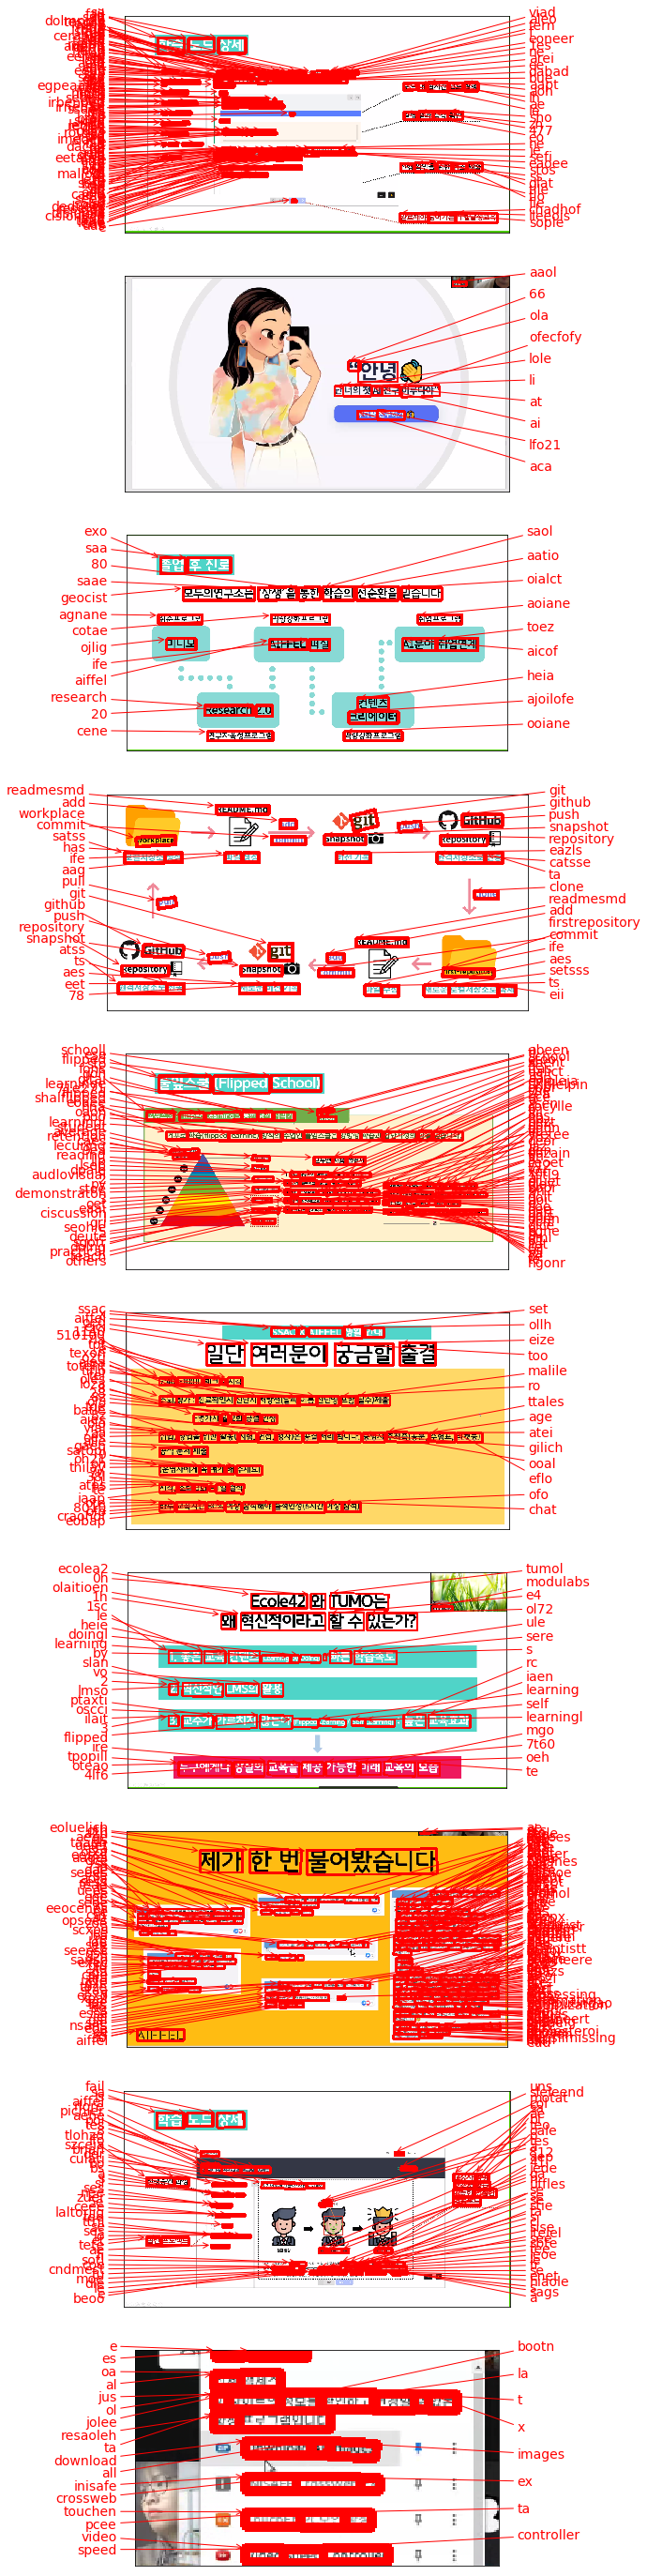

In [15]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(50, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract

1) 테서랙트 설치하기

```python
$ sudo apt install tesseract-ocr
$ sudo apt install libtesseract-dev
```

2) 테서랙트 파이썬 wrapper 설치하기

```python
$ pip install pytesseract
```

3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)

In [10]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_image.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/aiffel/aiffel/ocr_python/0000.png
/home/aiffel/aiffel/ocr_python/0001.png
/home/aiffel/aiffel/ocr_python/0002.png
/home/aiffel/aiffel/ocr_python/0003.png
/home/aiffel/aiffel/ocr_python/0004.png
/home/aiffel/aiffel/ocr_python/0005.png
/home/aiffel/aiffel/ocr_python/0006.png
/home/aiffel/aiffel/ocr_python/0007.png
/home/aiffel/aiffel/ocr_python/0008.png
/home/aiffel/aiffel/ocr_python/0009.png
/home/aiffel/aiffel/ocr_python/0010.png
/home/aiffel/aiffel/ocr_python/0011.png
/home/aiffel/aiffel/ocr_python/0012.png
/home/aiffel/aiffel/ocr_python/0013.png
/home/aiffel/aiffel/ocr_python/0014.png
/home/aiffel/aiffel/ocr_python/0015.png
/home/aiffel/aiffel/ocr_python/0016.png
/home/aiffel/aiffel/ocr_python/0017.png
/home/aiffel/aiffel/ocr_python/0018.png
/home/aiffel/aiffel/ocr_python/0019.png
/home/aiffel/aiffel/ocr_python/0020.png
/home/aiffel/aiffel/ocr_python/0021.png
/home/aiffel/aiffel/ocr_python/0022.png
/home/aiffel/aiffel/ocr_python/0023.png
/home/aiffel/aiffel/ocr_python/0024.png


(주의) 위 코드에서 lang='kor' 로 바꾸면 에러가 발생합니다. 테서랙트의 언어팩을 설치해야 정상동작하게 된다.

```python
$ sudo apt install tesseract-ocr-kor
```

4) 테서랙트로 잘린 이미지에서 단어 인식하기

In [11]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

문 ~ 러\

애외

이스

0

ㆍ

대

고

|

기


은

-…-

다양한

기

술

0

| 횡

『대

어

| 기여

숭

^

지식

숭유

소설

서비스

Done


## Step3. 테스트 결과 정리

사진에 글이 많고 복잡한데도 나름 잘 뽑았다고 생각한다.

## Step4. 결과 분석과 결론 제시

역시 시각적으로 가장 만족스러운 분석은 keras-ocr이다.    
하지만 한글을 영어로 인식한 부분은 좀 이해가 안된다.

## 회고

노드에서 따오기도 많이 따왔지만 아직 데이터를 불러오는 부분은 어렵고 또 팀원들이 돠와줬다.   
아무리 생각해도 아이펠의 큰 장점은 동료이다(물론 나처럼 쩌리 한정).   
내 테스트 사진이 매우 복잡한데도 나름 잘 뽑아냈다고 생각한다.